**Authorized to access Google Drive**

In [46]:
from google.colab import drive
drive.mount('/content/drive')

val_path = "/content/drive/My Drive/Colab Notebooks/MSc_project/dataset/validation/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import libraries**

In [0]:
%matplotlib inline

import numpy as np 
from keras.models import Model, load_model
from keras import backend as K
from skimage.transform import resize
from keras.utils import np_utils, plot_model
import matplotlib.pyplot as plt

**Use MIoU as evalutaion metrics**

In [0]:
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

In [0]:
def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

In [0]:
# imported code from https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
def precision(y_true, y_pred):
    # Calculates the precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    # Calculates the recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    # Calculates the F score, the weighted harmonic mean of precision and recall.

    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def fmeasure(y_true, y_pred):
    # Calculates the f-measure, the harmonic mean of precision and recall.
    return fbeta_score(y_true, y_pred, beta=1)
# import code end

**Build U-Net model using Keras**

24/24 [==============================] - 2s 82ms/step
[0.050087038427591324, 0.9855049252510071, 0.9608849883079529, 0.9800291061401367, 0.9859454035758972, 0.9835457801818848, 0.9883569478988647]
['loss', 'categorical_accuracy', 'iou_coef', 'dice_coef', 'fmeasure', 'recall', 'precision']


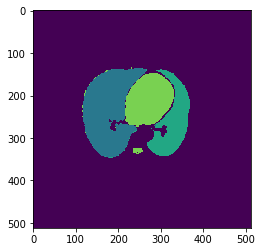

In [51]:
dependencies = {
    'precision': precision,
    'recall': recall,
    'fmeasure': fmeasure,
    'iou_coef': iou_coef,
    'dice_coef': dice_coef
}

model = load_model('/content/drive/My Drive/Colab Notebooks/MSc_project/experiment/models/Model_B.h5', custom_objects=dependencies)

test_num = 24
X_test = np.zeros((test_num, im_height, im_width, 3), dtype=np.uint8)
Y_test = np.zeros((test_num, im_height, im_width), dtype=np.uint8)

for i in range(test_num):
    img = np.load(val_path + 'images/' + str(i+1) +'_image.npy').transpose(1, 2, 0)
    x = img[:,:,:]
    x = resize(x, (512, 512, 3), mode='constant', preserve_range=True)
    X_test[i] = x
    
    mask = (np.load(val_path + 'masks/' + str(i+1) +'_mask.npy'))
    Y_test[i] = resize(mask, (512, 512), mode='constant', preserve_range=True)

Y_test_one_hot = np_utils.to_categorical(Y_test, 6) #np_utils.to_categorical for one hot encoding to no of label 

print(model.evaluate(X_test, Y_test_one_hot))
print(model.metrics_names)

predicted_mask = model.predict(X_test)
test_out = predicted_mask[5,:,:,:]
test_decode = np.argmax(test_out, axis=-1)
plt.imshow(test_decode)


**Prediction and results on validation**

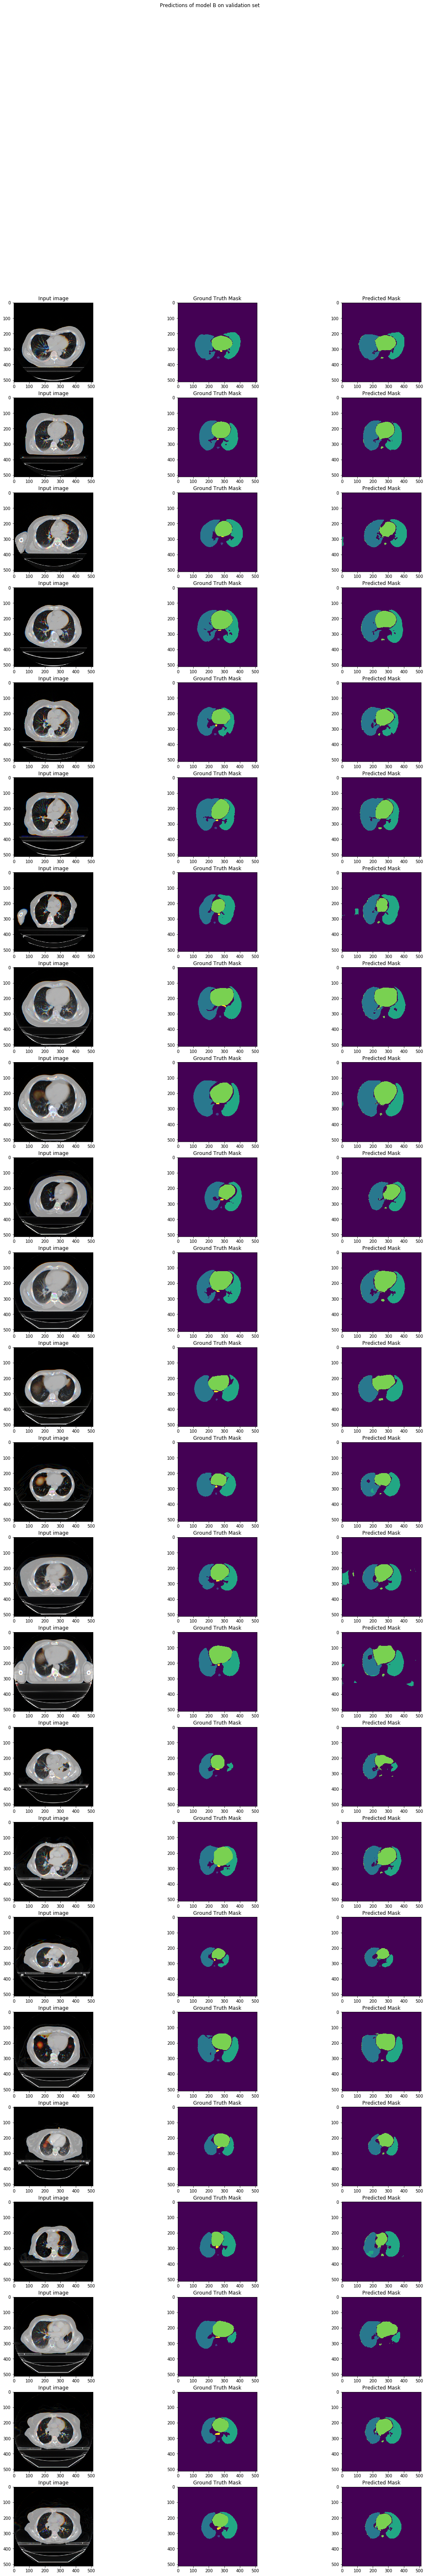

In [52]:
plt.figure(figsize=(20, 100))
for i in range(24):
  plt.subplot(24, 3, 3 * i + 1)
  plt.imshow(X_test[i])
  plt.title("Input image")
  
  plt.subplot(24, 3, 3 * i + 2)
  plt.imshow(Y_test[i])
  plt.title("Ground Truth Mask")
  plt.subplot(24, 3, 3 * i + 3)
  predicted = predicted_mask[i,:,:,:]
  predicted_decode = np.argmax(predicted, axis=-1)
  plt.imshow(predicted_decode)
  plt.title("Predicted Mask")
plt.suptitle("Predictions of model B on validation set")
plt.show()

**Visulization feature maps of any layer**

In [0]:
# n_layer = 32
# get_layer_output = K.function([model.layers[0].input], [model.layers[n_layer].output])

# print(get_layer_output.name)
# layer_output = get_layer_output([X_test])[0]
# print(layer_output.shape)

# # plt.matshow(layer_output[1], cmap='viridis')
# plt.figure(figsize=(20, 10))

# for _ in range(128):
#             show_img = layer_output[0, :, :, _]
#             show_img.shape = [512, 512]
#             plt.subplot(4, 8, _ + 1)
#             plt.imshow(show_img, cmap='viridis')
#             plt.axis('off')
# plt.show()
